Making this a part 2, since Andrej deletes a lot of crap from the video

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value(data={self.data}, label={self.label})'

    # addition
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # back propogation specifically for the addition
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    # negation, which will be used for subtraction
    def __neg__(self):
        return self * -1
    
    # subtraction--the addition of the negation of something else
    def __sub__(self, other):
        return self + (-other)
    
    # multiplication
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        # back propogation specifically for multiplication
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    # anything raised to any power by the power rule
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only suppporting ints and floats for now'
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other*self.data**(other-1)) * out.grad
            
        out._backward = _backward
        return out
    
    # true division for the constant k = -1 in (a/b) = a*b**-1
    def __truediv__(self, other):
        return self * other**-1
    
    # since python doesn't know the difference b/n e.g. 2 * a and a * 2
    # need a rescue function that'll save a failure from happening by reversing
    # order of multiplication
    def __rmul__(self, other):
        return self * other
    
    # temporary activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            # local derivative of e^x was just calculated for out
            # multiply this by out.grad for chen lu
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
        
    
    # backpropogation to be performed given neuron connections
    def backward(self):
        # first need to topologicall sort connected neurons
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        # build the topological sort to prepare for backpropogation
        build_topo(self)

        # now we want the back propogation to happen after the sort
        self.grad = 1.0 # since gradient of last neuron will be 1
        for node in reversed(topo):
            # will call whatever backprop method is needed from other methods
            node._backward()

In [58]:
from graphviz import Digraph

def trace(root):
    # construct graph with nodes and connected edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for every value in the graph, create a node for it
        dot.node(name = uid, label='{%s | data = %.2f | grad %.2f}' % (n.label, n.data, n.grad), shape='record')
        
        # if the current node is an operation, create a node for it
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [59]:
# instantiate inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# instantiate weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# now add things together 
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

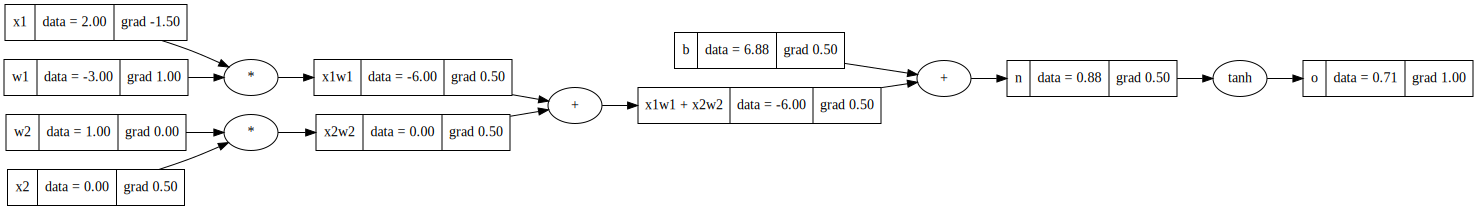

In [60]:
o.backward()
draw_dot(o)

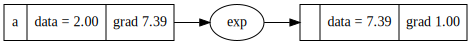

In [61]:
a = Value(2.0, label='a') 
b = a.exp(); label='b'
b.backward()
draw_dot(b)

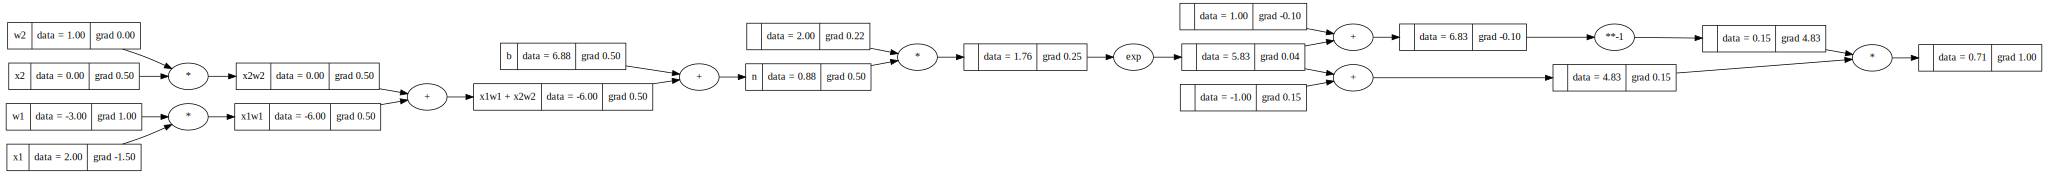

In [63]:
# instantiate inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# instantiate weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# now add things together 
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

# redefining o in terms of our new exponential function
e = (2*n).exp()
o = (e - 1) / (e + 1); label='o'
o.backward()
draw_dot(o)

Now let's nuke all of what we've done so far and just use PyTorch to do everything

In [65]:
import torch

In [76]:
# python normally works with 64 bit floating points, but torch has 32, so this is 
# exactly recreating what we were just doing
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('w1', w1.grad.item())
o

0.7071066904050358
---
x2 0.5000001283844369
x1 -1.5000003851533106
w2 0.0
w1 1.0000002567688737


tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [77]:
o.item()

0.7071066904050358

In [73]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).dtype

torch.float32